

> # ***Review_Rating prediction with crawling live data from Amazon***

Using:
*   Gaussian Naive Bayes
*   K-Nearest Neighbour
*   Random Forest
*   Support Vector Machine (Linear SVC)
*   LSTM with PyTorch



```
Written by:

Amir Bahador Eizadkhah / eizadkhah.bit@gmail.com
Amin Nazarian Saralang / aminnazarian1987@gmail.com
```


---



## **1. Importing Libraries**

In [ ]:
pip install langdetect

In [ ]:
pip install translators --upgrade

In [ ]:
import requests
import re
import string
import time
import random
import translators as ts
from langdetect import detect
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import seaborn as sns
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from wordcloud import WordCloud

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torchtext
from torch.nn import CrossEntropyLoss

from google.colab import drive

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
def plot_proporsion(dataset, label):
    plt.figure(figsize=(6,6))
    plt.title('Percentage of category')
    ax = sns.countplot(y = label, data = dataset)
    total = len(dataset)
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width() / total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))

def plot_word_cloud(dataset, label):
    allw = ''
    for word in dataset[label]:
        allw += word

    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color ='white',
                          min_font_size = 10).generate(allw)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()



---


## **2. Importing Dataset**

Download ***Cell Phones and Accessories*** from the link bellow

[Dataset](https://forms.gle/UEkkJs69e7Z5A5Ps9)

Or uncomment the following code cell and run it which use [Reviews_Modified.csv](https://drive.google.com/file/d/1vCIvjK6l9vp2Tec5IkO_Aokn0V6oYhVI/view?usp=sharing), and skip parts 2, 3, 4, and jump to part 5 (Classification)

In [ ]:
# dataset = pd.read_csv('https://raw.githubusercontent.com/ebahador/NLP-With-Amazon-Crawling-Comments-with-LSTM/main/Dataset/Reviews_Modified.csv')

**Importing JSON and convert it to CSV**

In [ ]:
dataset_dir = '/content/drive/MyDrive/'
jsn = pd.read_json(dataset_dir + 'Cell_Phones_and_Accessories_5.json', lines=True)
jsn.to_csv (dataset_dir + 'cellphone.csv', index = False)

In [ ]:
df = pd.read_csv(dataset_dir + 'cellphone.csv')
ds = df[['TEXT', 'SCORE']].copy()

ds.columns = ['TEXT', 'SCORE']
ds.to_csv(dataset_dir + 'Reviews_Modified.csv', index =None)

Dataset shape: (24941, 2)
Maximum rating scale of overall rating 5.0
Minimum rating scale of overall rating 1.0
Class Labels: {1.0, 2.0, 3.0, 4.0, 5.0}


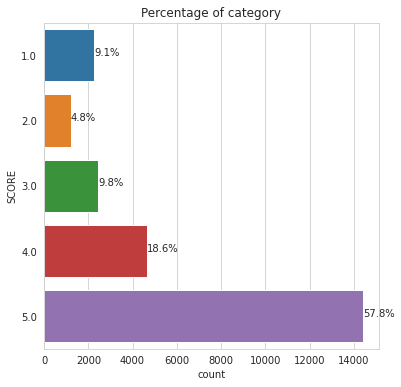

In [ ]:
ds = pd.read_csv(dataset_dir + 'Reviews_Modified.csv')
ds = ds.dropna()

print('Dataset shape:', np.shape(ds))
print('Maximum rating scale of overall rating {}'.format(ds.SCORE.max()))
print('Minimum rating scale of overall rating {}'.format(ds.SCORE.min()))
print('Class Labels:', set(sorted(ds.SCORE)))

ds.head()
plot_proporsion(dataset=ds, label='SCORE')

In [ ]:
assert isinstance(ds, pd.core.frame.DataFrame), 'Dataset is not pandas Dataframe'
assert len(set(sorted(ds.SCORE))) == 5, 'The number of labels are more than 5!'
assert min(set(sorted(ds.SCORE))) == 1 and max(set(sorted(ds.SCORE))) == 5, 'Labels are not between 1 to 5'
print("Passed!")

Passed!




---


## **3. Creawing**

In [ ]:
# Getting comments and reviews regarding the specific product

HEADERS = ({'User-Agent':
                'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
                AppleWebKit/537.36 (KHTML, like Gecko) \
                Chrome/100.0.4896.75 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'})


def getReviews(session, link):
    response = session.get(link, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'lxml')
    return soup.find_all('span', {'data-hook': 'review-body'})


def getRate(session, link):
    response = session.get(link, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'lxml')
    return soup.find_all('i', {'data-hook': 'review-star-rating'})

You can use the link below:

https://www.amazon.com/Apple-iPhone-XR-Fully-Unlocked/product-reviews/B07P6Y7954/ref=cm_cr_arp_d_paging_btm_next_0?ie=UTF8&reviewerType=all_reviews&pageNumber=0

In [ ]:
start_time = time.time()

X_tst = []
y_tst = []

FLAG = True
checking = 'https://www.amazon.'

while FLAG:
    link = input('Please put your Amazon link here: ')
    if checking in link:
        FLAG = False
    else:
        print('Your website either is not Amazon or has not observed "HTTPS" legislation.')

with requests.Session() as session:
    for i in range(500):
        for rates in getRate(session, link + str(i)):
            y_tst.append(f'{rates.text}\n'[0:3])
        for reviews in getReviews(session, link + str(i)):
            X_tst.append(f'{reviews.text}\n\n'[4:])

X_tst = np.asarray(X_tst)
y_tst = np.float64(np.asarray(y_tst))

data = {'TEXT': X_tst, 'SCORE': y_tst}

test_set = pd.DataFrame.dropna(pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()])))
print(test_set)
print(f'Total text cleaning time: {(time.time() - start_time)/60:.2f} min')

Please put your Amazon link here: https://www.amazon.com/Apple-iPhone-XR-Fully-Unlocked/product-reviews/B07P6Y7954/ref=cm_cr_arp_d_paging_btm_next_0?ie=UTF8&reviewerType=all_reviews&pageNumber=0
                                                   TEXT  SCORE
0     as a little sceptical buying this phone becaus...    5.0
1     s seller is amazing was a bit skeptical at fir...    5.0
2     t was told by my carrier, ATT, that this phone...    1.0
3     urchased this phone for my daughter and it cam...    4.0
4     on’t know why everyone’s giving this seller a ...    5.0
...                                                 ...    ...
4985  \n                    The media could not be l...    1.0
4986  eived my IPhone a few days ago and everything ...    5.0
4987  bsolutly LOVED this IPhone XR it was wonderful...    5.0
4988  l admit after reading through the reviews I wa...    5.0
4989  ate: 04/06/2021: I still have this phone. Stil...    5.0

[4990 rows x 2 columns]
Total text cleaning time

### 3.1 Proportion division

The number of unique comments are really ***low***.

**So, we can find the right proportion of testing and training data with the following formula:** 


\begin{align}
        trainsample = \frac{len(crawledData) * 0.8}{0.2}
    \end{align}

Dataset shape before crawling from Amazon: (19960, 2)
Dataset shape after crawling from Amazon: (24950, 2)


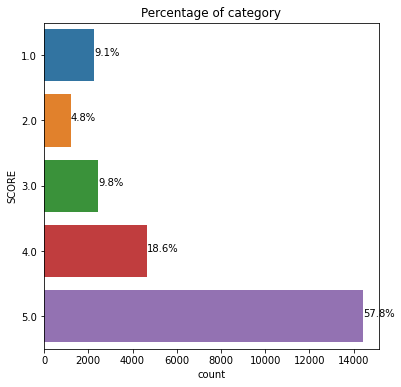

In [ ]:
train_sample = np.int32(np.round((len(test_set) * 0.8) / 0.2))
dataset = ds.sample(n=train_sample).reset_index(drop=True)
print('Dataset shape before crawling from Amazon:', np.shape(dataset))

dataset = dataset.append(test_set, ignore_index=True)
print('Dataset shape after crawling from Amazon:', np.shape(dataset))
plot_proporsion(dataset=dataset, label='SCORE')

In [ ]:
assert isinstance(train_sample, np.int32), 'Dataset is not pandas Dataframe'
assert np.shape(dataset) == (len(dataset.TEXT), 2), "Dataset has wrong shape"
print("Passed!")

Passed!




---


## **4. Data preprocessing**

### 4.1 Data Cleaning

In [ ]:
def clean(text):
    
    # converting the all the text into lowercase
    text = str(text).lower()
    
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    try:
        if detect(text=text) == 'en':
          text = re.sub('\[.*?\]', '', text)
          text = re.sub('https?://\S+|www\.\S+', '', text)
          text = re.sub('<.*?>+', '', text)
          text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
          text = re.sub('\n', '', text)
          text = re.sub('\w*\d\w*', '', text)
        else:
            if len(text.split()) < 750:
              text = ts.google(text , to_language = 'en')
              text = re.sub('\[.*?\]', '', text)
              text = re.sub('https?://\S+|www\.\S+', '', text)
              text = re.sub('<.*?>+', '', text)
              text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
              text = re.sub('\n', '', text)
              text = re.sub('\w*\d\w*', '', text)
            else:
              text = 'Perfect, I love it.'
              
    except:
      text = 'Perfect, I love it.'
    return text

In [ ]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
start_time = time.time()

dataset['TEXT'] = dataset.TEXT.apply(
    lambda x: clean(x))

dataset['TEXT'] = dataset.TEXT.apply(
    lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

dataset['TEXT'] = dataset.TEXT.apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

dataset['TEXT']= dataset.TEXT.apply(
    lambda x: ' '.join([ps.stem(word) for word in x.split()]))

dataset.columns = ['TEXT', 'SCORE']
dataset.to_csv(dataset_dir + 'Reviews_Modified.csv', index=None)

print(f'Total text cleaning time: {(time.time() - start_time)/60:.2f} min')
print(np.shape(dataset))
dataset.head()

Total text cleaning time: 10.55 min
(24950, 2)


,TEXT,SCORE
0,unlock phone use att tmobil phone differ chips...,5.0
1,well end go back old case reason fault case sa...,5.0
2,order case new dna debat sever differ case arr...,5.0
3,case bulki seem protect phone well sinc drop s...,5.0
4,love cover beauti blingi look great iphon incl...,5.0


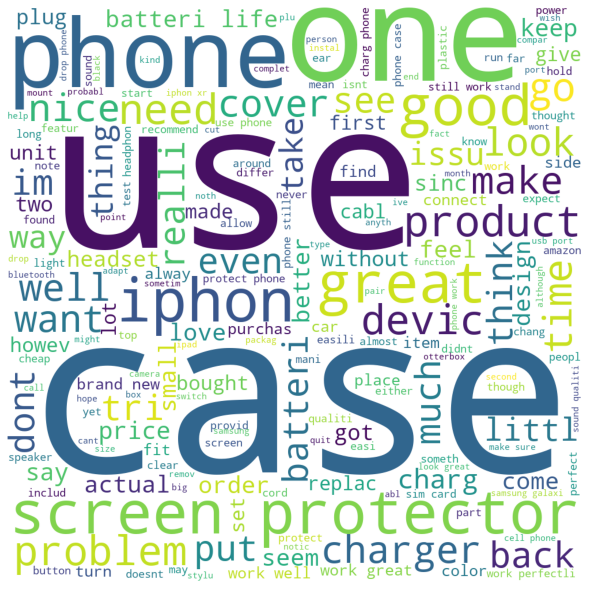

In [ ]:
plot_word_cloud(dataset, 'TEXT')

### 4.2 Vectorizing of dataset

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=6500, ngram_range=(1, 2), lowercase=True, norm='l2', analyzer='word')
X_vec = tfidf_vectorizer.fit_transform(dataset['TEXT'].values.astype('U'))
y_vec = dataset['SCORE']

X, y = SMOTE().fit_resample(X_vec, y_vec)

print('Shape of the feature matrix:', np.shape(X))

Shape of the feature matrix: (72100, 6500)


### 4.3 Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

print('Train Size:', np.shape(X_train))
print('Test Size:', np.shape(X_test))

Train Size: (57680, 6500)
Test Size: (14420, 6500)




---


> ## ***5. Classification with SK-Learn***

### **5.1 Classification**

#### 5.1.1 Implementing Support Vector Machine

In [ ]:
svm_classifier = LinearSVC(C=1000, loss='squared_hinge', dual=False, max_iter=10000, penalty='l2', random_state=0, multi_class='ovr')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

#### 5.1.2 Implementing Random Forest

In [ ]:
random_forest_classifier = RandomForestClassifier(n_estimators=300, random_state=0, criterion='gini', max_features='sqrt', warm_start=True)
random_forest_classifier.fit(X_train, y_train)
y_pred_rf = random_forest_classifier.predict(X_test)

#### 5.1.3 Implementing K-Nearest Neighbour

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2, weights='distance')
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

#### 5.1.4 Implementing Gaussian Naïve Bayes

In [ ]:
nb_classifier = GaussianNB(var_smoothing=1e-3)
nb_classifier.fit(X_train.toarray(), y_train)
y_pred_nb = nb_classifier.predict(X_test.toarray())

### **5.2 Classification Report**

In [ ]:
print('______________________ /Gaussian Naïve Bayes\ _______________________\n')
print('CLASSIFICATION REPORTS:\n')
print(classification_report(y_test, y_pred_nb, zero_division=0))
print('\nCONFUSION MATRIX:\n')
print(confusion_matrix(y_test, y_pred_nb))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_test, y_pred_nb) :.3f}')
print('____________________________________________________________________\n')

print('______________________ /K-Nearest Neighbour\ _______________________\n')
print('CLASSIFICATION REPORTS:\n')
print(classification_report(y_test, y_pred_knn, zero_division=0))
print('\nCONFUSION MATRIX:\n')
print(confusion_matrix(y_test, y_pred_knn))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_test, y_pred_knn) :.3f}')
print('____________________________________________________________________\n')

print('______________________ /Random Forest\ _______________________\n')
print('CLASSIFICATION REPORTS:\n')
print(classification_report(y_test, y_pred_rf, zero_division=0))
print('\nCONFUSION MATRIX:\n')
print(confusion_matrix(y_test, y_pred_rf))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_test, y_pred_rf) :.3f}')
print('____________________________________________________________________\n')

print('____________________ /Support Vector Machine\ _____________________\n')
print('CLASSIFICATION REPORTS:\n')
print(classification_report(y_test, y_pred_svm, zero_division=0))
print('\nCONFUSION MATRIX:\n')
print(confusion_matrix(y_test, y_pred_svm))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_test, y_pred_svm) :.3f}')

______________________ /Gaussian Naïve Bayes\ _______________________

CLASSIFICATION REPORTS:

              precision    recall  f1-score   support

         1.0       0.68      0.89      0.77      2939
         2.0       0.75      0.93      0.83      2897
         3.0       0.69      0.67      0.68      2860
         4.0       0.60      0.47      0.53      2827
         5.0       0.77      0.54      0.63      2897

    accuracy                           0.70     14420
   macro avg       0.70      0.70      0.69     14420
weighted avg       0.70      0.70      0.69     14420


CONFUSION MATRIX:

[[2602  148   79   40   70]
 [  95 2681   63   36   22]
 [ 371  302 1916  181   90]
 [ 574  257  381 1333  282]
 [ 194  185  338  624 1556]]

MEAN SQUARE ERROR: 1.274
____________________________________________________________________

______________________ /K-Nearest Neighbour\ _______________________

CLASSIFICATION REPORTS:

              precision    recall  f1-score   support

        



---


> ## ***6. LSTM with PyTorch***

### **6.1 Deep Learning**

In [ ]:
def plt_acc_loss(train, val, epochs, plttype):
    epochstoplot = range(1, epochs + 1)
    plt.plot(epochstoplot, train, label='Training ' + plttype)
    plt.plot(epochstoplot, val, label='validation ' + plttype)
    plt.title('Training and Validation ' + plttype)
    plt.xlabel('Epochs')
    plt.ylabel(plttype)
    plt.legend()
    plt.show()

def plt_ml_af(ml_models, svm, knn, rf, lstm, nb, figsize, ysize, ylabel):
    ml_acc_f1 = [nb, knn, lstm, svm, rf]
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)
    plt.yticks(ysize)
    plt.ylabel(ylabel)
    plt.xlabel("Machine Learning Models")
    sns.barplot(x=ml_models, y=ml_acc_f1)
    plt.show()

#### 6.1.1 Hyper Parameters

In [ ]:
RANDOM_SEED = 77
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

VOCABULARY_SIZE = 30000
LEARNING_RATE = 0.002
BATCH_SIZE = 40
NUM_EPOCHS = 25

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 5

PRE_TRAINED_MODEL_PARAMS = 'model_parameters.pth'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#### 6.1.2 Definition X and Y label and torch dataset

In [ ]:
X_torch_v = torchtext.legacy.data.Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    lower=True,
    batch_first=True
)

y_torch_v = torchtext.legacy.data.LabelField(dtype=torch.long, sequential=False, batch_first=True)

```

ATTENTION:

Uncomment the codes in cell bellow and run it, if you used Reviews_Modified,csv from GitHub dataset and skiped 2, 3, 4

```

In [ ]:
# dataset_torch = torchtext.legacy.data.TabularDataset(
#     path='https://raw.githubusercontent.com/ebahador/NLP-With-Amazon-Crawling-Comments-with-LSTM/main/Dataset/Reviews_Modified.csv', format='csv',
#     skip_header=True, fields=[(('TEXT'), X_torch_v), (('SCORE'), y_torch_v)])

```

ATTENTION:

Uncomment the codes in cell bellow and run it, if you used Cell_Phones_and_Accessories_5.json and converted into .csv

```

In [ ]:
# dataset_torch = torchtext.legacy.data.TabularDataset(
#     path=dataset_dir + 'Reviews_Modified.csv', format='csv',
#     skip_header=True, fields=[(('TEXT'), X_torch_v), (('SCORE'), y_torch_v)])

#### 6.1.3 Train Test Split

In [ ]:
train_data, test_data = dataset_torch.split(
    split_ratio=[0.8, 0.2],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Test: {len(test_data)}')

Num Train: 19960
Num Test: 4990


#### 6.1.4 Creating Validation Set

In [ ]:
train_data, valid_data = train_data.split(
    split_ratio=[0.90, 0.1],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Validation: {len(valid_data)}')

Num Train: 17964
Num Validation: 1996


In [ ]:
X_torch_v.build_vocab(train_data, max_size=VOCABULARY_SIZE)
y_torch_v.build_vocab(train_data)

print(f'Vocabulary size: {len(X_torch_v.vocab)}')
print(f'Number of classes: {len(y_torch_v.vocab)}')

Vocabulary size: 27253
Number of classes: 5


#### 6.1.5 Data Loader

In [ ]:
train_loader, _ = \
    torchtext.legacy.data.BucketIterator.splits(
        (train_data, _),
         batch_size=BATCH_SIZE,
         sort_within_batch=True,
         shuffle=True,
         sort_key=lambda x: len(x.TEXT),
         device=DEVICE)
    
_, valid_loader = \
    torchtext.legacy.data.BucketIterator.splits(
        (_, valid_data),
         batch_size=8,
         sort_within_batch=True,
         shuffle=False,
         sort_key=lambda x: len(x.TEXT),
         device=DEVICE)

print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.TEXT.size()}')
    print(f'Target vector size: {batch.SCORE.size()}')
    break

print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.TEXT.size()}')
    print(f'Target vector size: {batch.SCORE.size()}')
    break

Train
Text matrix size: torch.Size([40, 55])
Target vector size: torch.Size([40])

Valid:
Text matrix size: torch.Size([8, 2])
Target vector size: torch.Size([8])


In [ ]:
assert isinstance(train_loader, torchtext.legacy.data.iterator.BucketIterator), "Type of train loader is not correct!"
assert isinstance(valid_loader, torchtext.legacy.data.iterator.BucketIterator), "Type of validation loader is not correct!"
assert batch.SCORE.size(0) != 0, 'the size final size cannot be set to 0'
print('Passed!')

Passed!


### **6.2 Training the Neural Networks**

#### 6.2.1 Building the Model

In ***forward*** method:

```
NOTE: len(X_torch_v.vocab) -> sentence lengh
```

* The dimensionality of input ***X*** is [sentence lengh, batch size]

* The dimensionality of ***embedding_dim*** is [sentence length, batch size, embedding dim]

* Also, ***output*** shape is [sentence length, batch size, hidden_dim]

* ***hidden*** shape is [1, batch size, hidden_dim]

* After squeeze, the shape would be [batch size, hidden_dim]

In [ ]:
class LSTM(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, X):        
        embedded = self.embedding(X)
        output, (hidden, cell) = self.rnn(embedded)
        hidden.squeeze_(0)
        
        output = self.linear(hidden)

        return output

In [ ]:
print(LSTM(input_dim=len(X_torch_v.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES))

LSTM(
  (embedding): Embedding(27253, 128)
  (rnn): LSTM(128, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=5, bias=True)
)


#### 6.2.2 Training the RNN Model

In [ ]:
def measure_acc(y_predict, y_test):
    y_pred_softmax = torch.log_softmax(y_predict, dim=1)
    _, y_pred = torch.max(y_pred_softmax, dim=1)
    correct_pred = (y_pred == y_test).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    accuracy = torch.round(accuracy * 100)
    return accuracy

Training with train set and validation set (Colab GPU required)

Easily follow the steps below to turn on your Colab GPU:

* Click on Runtime -> Change runtime type

* Below the Hardware accelerator you can see None, GPU, TPU

* Click on GPU and Save

In [ ]:
start_time = time.time()

accuracy_stats = {
    'train': [],
    "validation": []
}

loss_stats = {
    'train': [],
    'validation': []
}

model = LSTM(input_dim=len(X_torch_v.vocab), embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=NUM_CLASSES)

pre_trained_model = False
try:
  model.load_state_dict(torch.load(PRE_TRAINED_MODEL_PARAMS))
  model.eval()
  pre_trained_model = True
  print('Using pretrained model...')

except:
  print('Training begins!')
  model = model.to(DEVICE)
  loss = CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

  for epoch in tqdm(range(NUM_EPOCHS)):
      train_epoch_loss = 0
      train_epoch_acc = 0
      model.train()
      for batch_idx, batch_data in enumerate(train_loader):
          
          X_tr_torch = batch_data.TEXT.to(DEVICE)
          y_tr_torch = batch_data.SCORE.to(DEVICE)

          logits = model(X_tr_torch)
          l = loss(logits, y_tr_torch)

          optimizer.zero_grad()
          l.backward()
          optimizer.step()

          train_acc = measure_acc(logits, y_tr_torch)

          train_epoch_loss += l.item()
          train_epoch_acc += train_acc.item()
      
      with torch.no_grad():
          val_epoch_loss = 0
          val_epoch_acc = 0
          model.eval()

          for batch_idx_val, batch_data_val in enumerate(valid_loader):

              X_val_torch = batch_data.TEXT.to(DEVICE)
              y_val_torch = batch_data.SCORE.to(DEVICE)

              logits_val = model(X_val_torch)
              loss_val = loss(logits_val, y_val_torch)

              val_acc = measure_acc(logits_val, y_val_torch)
              val_epoch_loss += loss_val.item()
              val_epoch_acc += val_acc.item()

      if (epoch + 1) % 5 == 0:
            print(
                f'Epochs {epoch + 1:03d} / {NUM_EPOCHS:03d}: | Train Loss: {train_epoch_loss / len(train_loader):.4f} '
                f'| Validation Loss: {val_epoch_loss / len(valid_loader):.4f} '
                f'| Train Accuracy: {train_epoch_acc / len(train_loader):.3f}'
                f'| Validation Accuracy: {val_epoch_acc / len(valid_loader):.2f}')

      loss_stats['train'].append(train_epoch_loss / len(train_loader))
      loss_stats['validation'].append(val_epoch_loss / len(valid_loader))
      accuracy_stats['train'].append(train_epoch_acc / len(train_loader))
      accuracy_stats['validation'].append(val_epoch_acc / len(valid_loader))
      
if not pre_trained_model:
  torch.save(model.state_dict(), '/content/drive/MyDrive/model_parameters.pth')
  
print('\nTraining is completed!')
print('_____________________________')
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

Training begins!


  0%|          | 0/25 [00:00<?, ?it/s]

Epochs 005 / 025: | Train Loss: 0.4849 | Validation Loss: 0.4054 | Train Accuracy: 82.644| Validation Accuracy: 90.00
Epochs 010 / 025: | Train Loss: 0.0631 | Validation Loss: 0.0754 | Train Accuracy: 98.680| Validation Accuracy: 98.00
Epochs 015 / 025: | Train Loss: 0.0564 | Validation Loss: 0.0045 | Train Accuracy: 98.689| Validation Accuracy: 100.00
Epochs 020 / 025: | Train Loss: 0.0371 | Validation Loss: 0.0075 | Train Accuracy: 99.207| Validation Accuracy: 100.00
Epochs 025 / 025: | Train Loss: 0.0385 | Validation Loss: 0.0026 | Train Accuracy: 99.193| Validation Accuracy: 100.00

Training is completed!
_____________________________
Total Training Time: 1.55 min


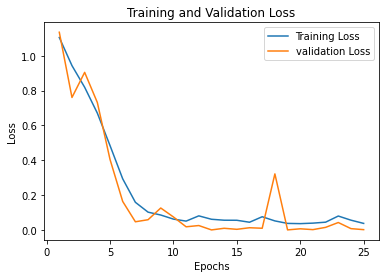

In [ ]:
if pre_trained_model == False:
  plt_acc_loss(loss_stats['train'], loss_stats['validation'], NUM_EPOCHS, 'Loss')

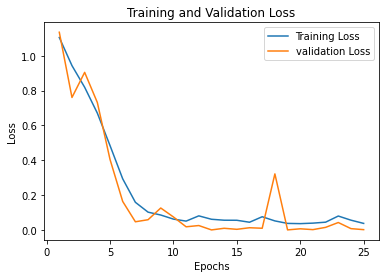

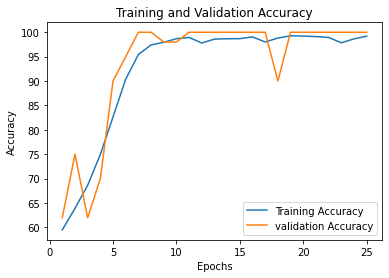

In [ ]:
if pre_trained_model == False:
  plt_acc_loss(accuracy_stats['train'], accuracy_stats['validation'], NUM_EPOCHS, 'Accuracy')

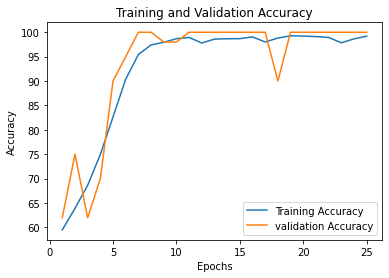

### 6.3 Testing the RNN Model

##### 6.3.1 testing

It would take to much time if we want to set the test set batch size manually.

So, Its better to let a simple for loop do it.

The for loop pass the ***test_model*** method, a number between 3 to 128 in each iteration.

The following method finds the best batch size for test data.

In [ ]:
def test_model(batch_size):
    k, test_loader = torchtext.legacy.data.BucketIterator.splits(
        (train_data, test_data),
         batch_size=batch_size,
         sort_within_batch=False,
         shuffle=True,
         sort_key=lambda x: len(x.TEXT),
         device=DEVICE)
    y_pred_list = []
    y_true_list = []

    model.eval()
    with torch.no_grad():
        for X_test_torch, y_test_torch in test_loader:
            X_test_t, y_test_t = X_test_torch.to(DEVICE), y_test_torch.to(DEVICE)

            y_torch_pred = model(X_test_t)
            _, y_t_pred = torch.max(y_torch_pred, dim=-1)

            y_pred_list.append(y_t_pred.cpu().numpy())
            y_true_list.append(y_test_t.cpu().numpy())

    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]

    return y_true_list, y_pred_list

In [ ]:
batch_size_vals = []

y_pred_list = []
y_true_list = []

start_batch = 3

for i in range(start_batch, 129):
    y_true_list, y_pred_list = test_model(i)
    batch_size_vals.append(accuracy_score(y_true_list, y_pred_list))

In [ ]:
y_pred_list = []
y_true_list = []
y_true_list, y_pred_list = test_model(batch_size_vals.index(max(batch_size_vals)) + start_batch)

### **6.4 Classification Report**

In [ ]:
print('____________________ /LSTM\ _____________________\n')
print('CLASSIFICATION REPORTS\n')
print(classification_report(y_true_list, y_pred_list, zero_division=0))
print('\nCONFUSION MATRIX\n')
print(confusion_matrix(y_true_list, y_pred_list))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_true_list, y_pred_list) :.3f}')

____________________ /LSTM\ _____________________

CLASSIFICATION REPORTS

              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.62      0.71      0.67         7
           2       0.50      0.43      0.46         7
           3       0.80      0.80      0.80         5
           4       0.33      1.00      0.50         1

    accuracy                           0.78        49
   macro avg       0.64      0.76      0.66        49
weighted avg       0.80      0.78      0.78        49


CONFUSION MATRIX

[[25  2  2  0  0]
 [ 1  5  1  0  0]
 [ 1  1  3  1  1]
 [ 0  0  0  4  1]
 [ 0  0  0  0  1]]

MEAN SQUARE ERROR: 0.469


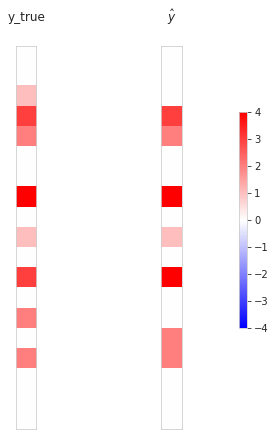

In [ ]:
tensor_dict = {
    'y_true': torch.FloatTensor(y_true_list[1:20]),
    '$\hat{y}$': torch.FloatTensor(y_pred_list[1:20])
    }

n = len(tensor_dict)
vmax = max(v.abs().max() for v in tensor_dict.values())
figsize = (2 * n, 6)
fig, axes = plt.subplots(1, n, figsize=figsize, constrained_layout=True, squeeze=True)
axes = axes.flat if isinstance(axes, np.ndarray) else (axes,)
for (name, v), ax in zip(tensor_dict.items(), axes):
    v = torch.squeeze(v.detach())
    if v.ndim == 1:
        v = v.view(-1, 1)
    img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap('bwr'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)
fig.colorbar(img, cax=fig.add_axes([0.985, 0.25, 0.03, .5]))



---


## **7. Overal Results**

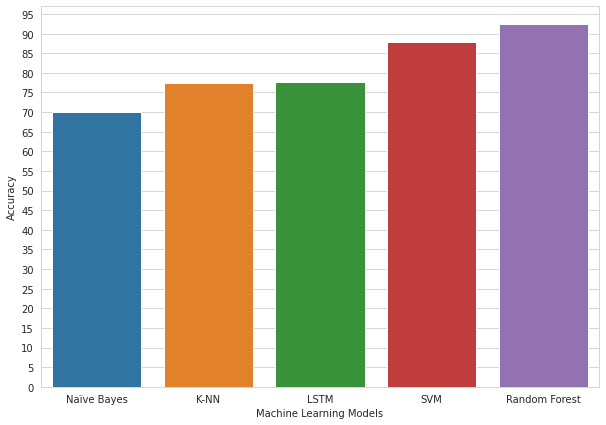

In [ ]:
ml_models = ['Naïve Bayes', 'K-NN', 'LSTM', 'SVM', 'Random Forest']

svm_acc = round(accuracy_score(y_test, y_pred_svm) * 100, 2)
knn_acc = round(accuracy_score(y_test, y_pred_knn) * 100, 2)
rf_acc = round(accuracy_score(y_test, y_pred_rf) * 100, 2)
lstm_acc = round(accuracy_score(y_true_list, y_pred_list) * 100, 2)
nb_acc = round(accuracy_score(y_test, y_pred_nb) * 100, 2)

plt_ml_af(ml_models, svm_acc, knn_acc, rf_acc, lstm_acc, nb_acc, (10,7), np.arange(0, 100, 5), "Accuracy")

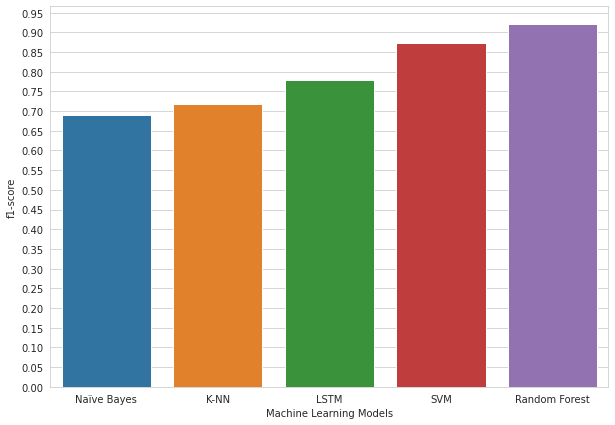

In [ ]:
svm_f1 = round(f1_score(y_test, y_pred_svm, average='weighted'), 3)
knn_f1 = round(f1_score(y_test, y_pred_knn, average='weighted'), 3)
rf_f1 = round(f1_score(y_test, y_pred_rf, average='weighted'), 2)
lstm_f1 = round(f1_score(y_true_list, y_pred_list, average='weighted'), 2)
nb_f1 = round(f1_score(y_test, y_pred_nb, average='weighted'), 3)

plt_ml_af(ml_models, svm_f1, knn_f1, rf_f1, lstm_f1, nb_f1, (10,7), np.linspace(0, 1, 21), "f1-score")